# Stack Overflow Survey Analysis

## Introduction

### Purpose

To demonstrate CRISP-DM compliance where applicable of an end-to-end Data Science project while answering the following questions regarding the survey dataset:
1. How happy (satisfied) are developers in 2024?
2. Do you enjoy coding more if you do it as a hobby?
3. Does job satisfaction as a developer have any impact (positive or negative) on your compensation?
4. What are the factors of coding that make being a developer the most and least satisfactory?

## 1: Business Understanding
A few of our intial questions are answered by the provided PDF document on the [dataset main page](https://survey.stackoverflow.co/) residing on Stack Overflow. Within this PDF, we can see the the dataset contains questions for developers leverage the tech-based platform that is designed for programming-inclined SME's - Stack Overflow. 

These questions range from various background inquiries to further recommendations and more. As part of the survey, users are questioned about their job satisfaction. We will explore some of the relationships with job satisfaction based on the questions asked above.

## 2: Data Understanding
In order to develop a more in-depth understanding of the data, we will begin by loading the CSV-file dataset (obtainable from the link referenced above) into a Pandas dataframe and begin our data exploration.

In [557]:
# Importing required libraries for our end-to-end ML project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Loading data from 2024 survey into DF, running df.head() to verify records have been loaded successfuly
df = pd.read_csv('./Data/survey_results_public.csv')
schema = pd.read_csv('./Data/survey_results_schema.csv')

# Viewing complete number of rows and columns in the dataset
print(f"Survey Results Public: Rows - {df.shape[0]}, Columns - {df.shape[1]}")
print(f"Survey Results Schema: Rows - {schema.shape[0]}, Columns - {schema.shape[1]}")

Survey Results Public: Rows - 65437, Columns - 114
Survey Results Schema: Rows - 87, Columns - 6


In [558]:
# Verify our data has been loaded correctly
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,"Which of the following options best describes you today? For the purpose of this survey, a developer is ""someone who writes code"".*",True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your current employment status? Select all that apply.*,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying attention to the survey questions. Select ‘Apples’ from the list and you can get back to the survey.*<br><br>,True,MC,SAVR


Now that we have loaded our data successfully, we will start by doing some exploratory analysis through the usage of visualizations.

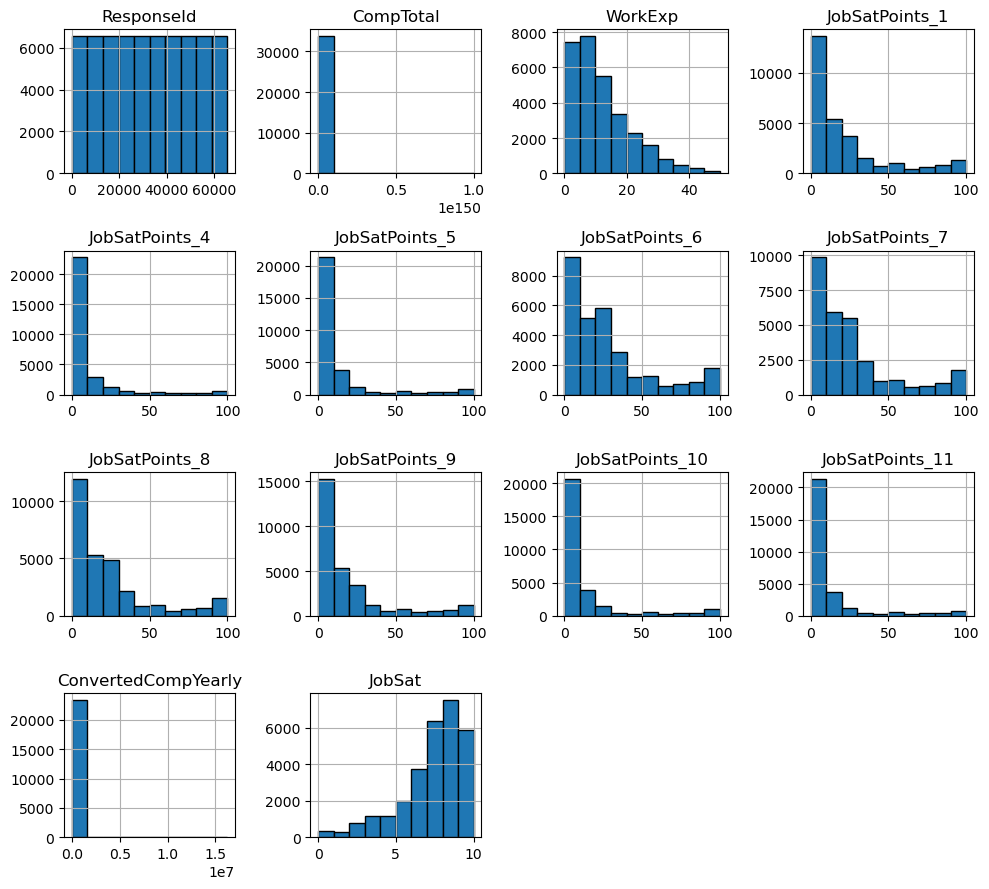

In [559]:
# Display a series of histograms, leveraging tight_layout to display readable outputs
df.hist(figsize=(10,9), ec="k")
plt.tight_layout()
plt.show()

The implication of the above is that there are zero records where survey responders have marked "2" or "3" for job satisfaction. Let us verify this below:

In [560]:
# Verifying the lack of Job SatPoints 2 and 3 within the dataset
list(df.loc[:, df.columns.str.contains("JobSatPoints")].columns)

['JobSatPoints_1',
 'JobSatPoints_4',
 'JobSatPoints_5',
 'JobSatPoints_6',
 'JobSatPoints_7',
 'JobSatPoints_8',
 'JobSatPoints_9',
 'JobSatPoints_10',
 'JobSatPoints_11']

Let us further answer some lingering questions by digging into the schema of the dataset. The result below shows us that these JobSatPoints parameters are satisfaction ratings pertaining to specific questions in the survey. Furthermore, our supposition that JobSat refers to overall job satisfaction in the role is confirmed.

In [561]:
# Explore the underlying schema behind the Job Satisfaction questions
jobsat_schema = schema[schema.qname.str.contains("JobSat")]
pd.set_option('max_colwidth', 400)
jobsat_schema[["qname", "question"]]

,qname,question
61,JobSat,How satisfied are you in your current professional developer role?
62,JobSatPoints,Assign points to the following attributes of your job according to those that contribute the most to your satisfaction out of 100 total points:
78,JobSatPoints_1,Driving strategy for my team
79,JobSatPoints_4,Contributing to open source
80,JobSatPoints_5,Securing data and environments
81,JobSatPoints_6,Improving quality of code and developer environments
82,JobSatPoints_7,"Learning and using new technology, including platforms, APIs and libraries"
83,JobSatPoints_8,"Designing and building environments, databases, and all things architecture"
84,JobSatPoints_9,"Being a power user of a tool, developer language or process that others come to for answers and guidance about"
85,JobSatPoints_10,Working with new and/or top-quality hardware


Furthermore, the above understanding of these questions will allow us to highlight more actionable insights when we dive into our questions.

## 3: Data Preparation

In [562]:
# Checking on the null values within the dataset using a simple one-liner
nulls = df.isnull().mean().sort_values(ascending=False)
nulls

AINextMuch less integrated    0.982456
AINextLess integrated         0.964011
AINextNo change               0.809007
AINextMuch more integrated    0.794642
EmbeddedAdmired               0.744288
                                ...   
MainBranch                    0.000000
Check                         0.000000
Employment                    0.000000
Age                           0.000000
ResponseId                    0.000000
Length: 114, dtype: float64

Based on the above, we can see that several questions relating to the integration of AI have > 75% null values, as such it will be more valuable to us to drop these columns from our dataset for consideration.

In [563]:
# Let us filter out the responses with a high threshold of null values, we are using .loc combined with : to scan the entire column
df = df.loc[:, df.isnull().mean() < 0.75]

Now that we have removed the columns that contain an unusable amount of null values, we will now examine the null values for Job Satisfaction parameters.

In [564]:
# Build a dataframe to store the null proportions of our columns, and then filter for thos columns pertinent to Job Satisfaction
sat_nulls = pd.DataFrame({'Column': nulls.index, 'Null Proportion': nulls.values})
sat_nulls[sat_nulls["Column"].str.contains("JobSat")]

,Column,Null Proportion
29,JobSat,0.554900
30,JobSatPoints_1,0.551874
31,JobSatPoints_4,0.550820
32,JobSatPoints_5,0.550545
33,JobSatPoints_11,0.550025
34,JobSatPoints_7,0.549979
35,JobSatPoints_6,0.549949
36,JobSatPoints_10,0.549949
37,JobSatPoints_8,0.549857
38,JobSatPoints_9,0.549857


Based on the above result, we can see that only ~45% of survey respondees have provided us with information about their job satisfaction. In order to address this, we will be building a separate dataframe for all respondees that have with a Null JobSat for further analyis. This operation is performed below.

In [565]:
# Handling Nulls, we will be separating out our analysis into two segments - those with job satisfaction information and those without
sat_nulls_df = df[df.JobSat.isnull()]
sat_df = df.dropna(subset=['JobSat'])

## Questions
### 1. How happy (satisfied) are developers in 2024?

In [566]:
# Let us take at the job satisfaction statistics, particularly the mean to see how developers are feeling in general about their jobs
sat_df.JobSat.describe()

count    29126.000000
mean         6.935041
std          2.088259
min          0.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: JobSat, dtype: float64

This is a good sign, let's create a simple visualization to view these results graphically. 

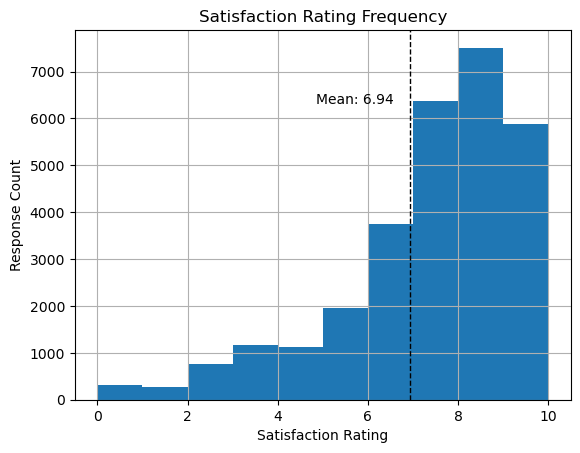

In [567]:
# Grab mean of job satisfaction 
sat_mean = sat_df['JobSat'].mean()

# Build histogram to showcase frequency
sat_df['JobSat'].hist()

# Plot mean line
plt.axvline(sat_mean, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()

# Label mean and apply titles
plt.text(sat_mean*0.7, max_ylim*0.8, 'Mean: {:.2f}'.format(sat_mean))
plt.title("Satisfaction Rating Frequency")
plt.xlabel("Satisfaction Rating")
plt.ylabel("Response Count")
plt.show()

__Answer:__ Based on the above results, we can say that, on average, developers are considerably happy in their current roles based on the data that we have available in this survey. From a scale from 0 (not at all satisfied) to 10 (extremely satisfied) they have an average job satisfaction rating of 6.9. We will continue to use the above information and plot it against other parameters to see if there is any meaningful correlation between job satisfaction and other factors.

### 2. Do you enjoy coding more if you do it as a hobby?

In order to answer this question we will now consider the status "MainBranch" which, based on the provided schema, is one of the first questions asked in the survey and allows us to determine what type of developer the respondee is. This includes professional developers as well as hobbyists.

In [568]:
# Step 1: Explode the 'values' column
exploded_df = sat_df.explode('MainBranch')

# Step 2: Group by the exploded values and count
count_df = exploded_df.groupby('MainBranch').size().reset_index(name='count').sort_values(by = 'count', ascending = False)
count_df

,MainBranch,count
0,I am a developer by profession,26627
2,"I am not primarily a developer, but I write code sometimes as part of my work/studies",1851
4,"I used to be a developer by profession, but no longer am",403
1,I am learning to code,138
3,I code primarily as a hobby,107


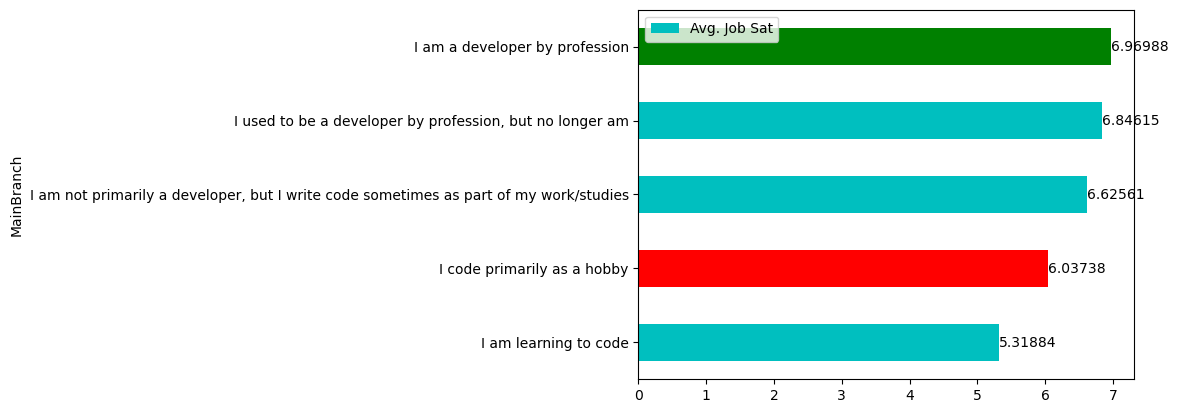

In [569]:

branch_sat_df = exploded_df.groupby('MainBranch')['JobSat'].mean().reset_index(name='Avg. Job Sat').sort_values(by = 'Avg. Job Sat', ascending = True)
ax = branch_sat_df.plot.barh(x = 'MainBranch', y = 'Avg. Job Sat', color = ['c', 'red', 'c', 'c', 'green'])
ax.bar_label(ax.containers[0])
plt.show()


__Answer:__ based on the results of our dataset, we can see that those who code primarily as a hobby actually have a __lower__ job satisfaction that those who are a developer by profession. Furthermore. Those who are a developer by profession is the group of individuals who have the __highest__ job satisfaction out of all main branches. 

### 3. Does job satisfaction as a developer have any impact (positive or negative) on your compensation?

First of all, let us kick off our solution by attempting to view a scatter plot of pay (ConvertedCompYearly) vs job satisfaction (JobSat).

<Figure size 640x480 with 0 Axes>

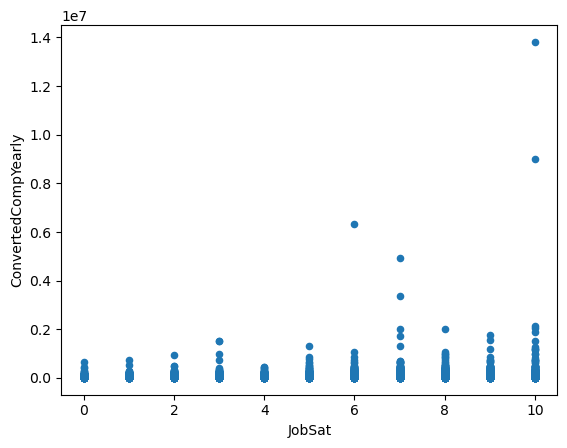

In [570]:
# Create our first scatter plot to give us a direction on where to proceed
plt.clf()
sat_df.plot.scatter('JobSat', 'ConvertedCompYearly')
plt.show()

From the above scatter plot, we can see that there are a few outliers that are making it more difficlt to spot patterns. We will apply a filter to exclude these outliers and see if we can identify a statistically significant correlation.

In [571]:
# In order to better prepare our data, let us now filter null values included in ConvertedCompYearly to apply into a linear model
sat_df = sat_df.dropna(subset=['ConvertedCompYearly'])

# After this, apply a range of compensation values, only consider those <= 2M, which removes outliers skewing the plot
sat_df = sat_df.drop(sat_df[sat_df['ConvertedCompYearly'] > 2000000].index)

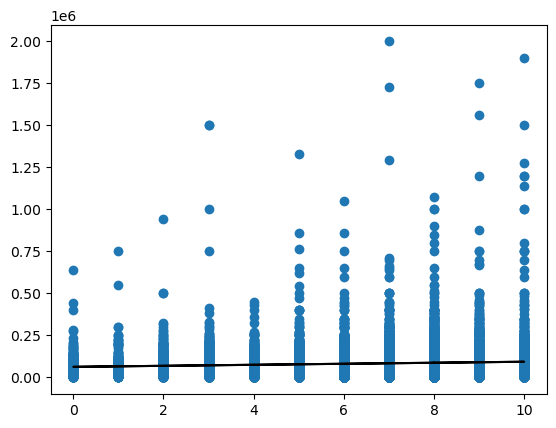

In [572]:
x = sat_df[['JobSat']]
y = sat_df[['ConvertedCompYearly']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .30, random_state=42)

lm_model = LinearRegression() # Here you could set any hyperparameters of your model
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)

# Clear state of plot
plt.clf()

# Add points to plot
plt.scatter(x, y)

plt.plot(X_test, y_test_preds, color = 'k')
plt.show()

In [573]:
r2 = r2_score(y_test, y_test_preds)
print(f"R-Squared for the above regression model considering (only) compensation as a predictor of job satisfaction: {r2}")

R-Squared for the above regression model considering (only) compensation as a predictor of job satisfaction: 0.0016874329635718777


__Answer:__ The above results are not looking good for compensation as a predictor of job satisfaction - perhaps that is a good thing in the big picture? Building a simple regression model only taking into consideration compensation gives us an R-squared value of 0.002 which means that only 0.2% of the variance of job satisfaction is explained by our ConvertedCompYearly parameter. This definitely informs us that it is a statistically insignificant predictor of job satisfaction.

### 4. What are the factors of coding that make being a developer the most and least satisfactory?

Before proceeding to see if we can build a useful predictive model, let us take a look at a heatmap correlation matrix to see if any of the other numerical attributes could combine to form a predictor of job satisfaction.

<Figure size 640x480 with 0 Axes>

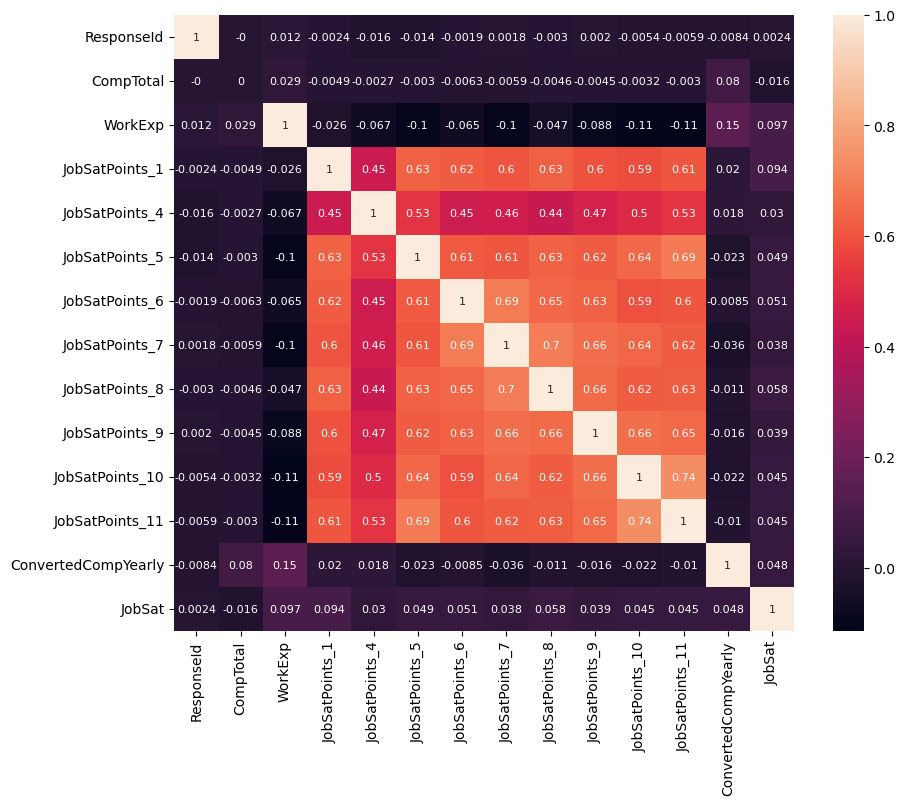

In [574]:
# Clear state of plot
plt.clf()

# Create heatmap correlation plot
fig, ax = plt.subplots(figsize=(10,8))  
sns.heatmap(df.corr(numeric_only= True), annot = True, annot_kws={'size': 8}, ax = ax)
plt.show()

Interestingly enough, we see that none of the numerical attributes are a very good predictor of the job satisfaction rating respondees have inputed in the survey. This is a little confusing, but all is not lost! If we reference the original survey, we see that the JobSatPoints attributes pertain to ratings that are provided on the following question:

> _Assign points to the following attributes of your job according to those that contribute the most to your satisfaction out of 100 total points:_

If this is the case, we can simply leverage the information provided in the JobSatPoints attributes to form our answer for this question.

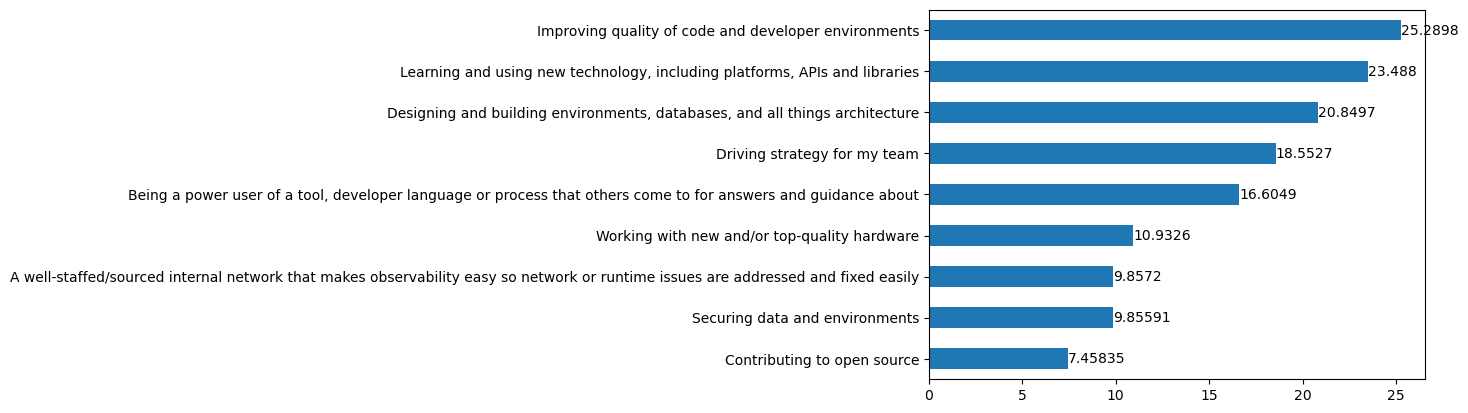

In [575]:
# Create list of job satisfaction questions
jobsat_list = ['JobSatPoints_1', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', \
               'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11']

# Create dataframe of job satisfaction questions
jobsatpoints_df = sat_df[jobsat_list]

questions = [] # Initialize list and turn question names into full question strings

for item in jobsat_list:
    questions.append(schema[schema['qname'] == item]['question'].values[0])

# Rename each column to the proper name for later usage
jobsatpoints_df.columns = questions

# Clear state of plot and build bar chart visualization, including labels
plt.clf()
ax = jobsatpoints_df.mean().sort_values(ascending = True).plot.barh()
ax.bar_label(ax.containers[0])
plt.show()

__Answer:__ According to the above result, we can see that respondees to the survey attribute the highest amount of improved job satisfaction towards 

<ol>
    <li>Improving quality of code and developer environments</li>
    <li>Learning and using new technology, including platforms, APIs and libraries, and</li>
    <li>Designing and building environments, databases and all things architecture</li>
</ol>

## Results
According to our analysis, the most effective way to improve job satisfaction for developers is to improve code quality and environments, incorporate learning and using of new technology into their workflows, and being involved in the design and construction of new environments, databases and more. With the data at hand, these factors are the top 3 ways that have been identified to improve job satisfaction as a developer.